In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

from runners.vStirapRunner import ExperimentalRunner, Atom, Cavity, CavityBiref, LaserCoupling, CavityCoupling

### Single 3-level system simulation

Here we will just demo how to set up, run and analyse a single three-level system using the [vStirapRunner](runners.vStirapRunner).

In [2]:
'''
Set up system
'''

'''
class Atom(RunnerDataClass):
    atom_states: dict = field(default_factory=dict)
    M: int = 4
    gamma: float = 3 * 2. * np.pi
    branching_ratios: list = field(default_factory=list)
    R_AL: np.matrix = np.sqrt(1 / 2) * np.matrix([[1, i],
                                                  [i, 1]])
'''
gamma=3 * 2. * np.pi
branching_ratios = [0,0,1]

atom=Atom(gamma=gamma,
          branching_ratios=branching_ratios)

'''
class CavityBiref(RunnerDataClass):
    N: int = 2
    cavity_states: list = field(default_factory=list)
    g: float = 3 * 2. * np.pi
    kappa1: float = 3 * 2. * np.pi
    kappa2: float = 3 * 2. * np.pi
    deltaP: float = 0 * 2. * np.pi
    R_CL: np.matrix = np.matrix([[1, 0],
                                 [0, 1]])
    R_ML: np.matrix = np.sqrt(1 / 2) * np.matrix([[1, i],
                                                  [i, 1]])
'''
g0=24 * (2*np.pi)
kappa1,kappa2 = 19 * 2.*np.pi, 0.9 * 2.*np.pi
deltaP = 20 * 2.*np.pi

cavity=CavityBiref(g=g0,
                   kappa1=kappa1,
                   kappa2=kappa2,
                   deltaP=deltaP)

'''
class LaserCoupling(RunnerDataClass):
    omega0: float
    g: str
    x: str
    deltaL: float
    args_ham: dict
    pulse_shape: str = 'np.piecewise(t, [t<length_pulse], [np.sin((np.pi/length_pulse)*t)**2,0])'
'''
deltaL=0
length_pulse = 1
omega0=20 * 2 * np.pi

laser_couplings = []

for g_state, x_state, delta, _ in Atom.get_couplings_sigma_plus(deltaL):
    laser_couplings.append(LaserCoupling(omega0=omega0,
                                         g=g_state,
                                         x=x_state,
                                         deltaL=delta,
                                         args_ham={"length_pulse":length_pulse}))
    
'''
class CavityCoupling(RunnerDataClass):
    g0: float
    g: str
    x: str
    deltaC: float
    deltaM: int
'''
deltaC=0
cavity_couplings = []

for g_state, x_state, delta, deltaM in Atom.get_couplings_sigma_minus(deltaC):
    cavity_couplings.append(CavityCoupling(g0=cavity.g,
                                           g=g_state,
                                           x=x_state,
                                           deltaC=delta,
                                           deltaM=deltaM))

In [3]:
runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=False)

In [4]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

results = runner.run(psi0=psi0)

Photon emission: 0.958
Photon emission in |X>, |Y>: 0.479 0.479
Spontaneous emission: 0.031


(<matplotlib.figure.Figure at 0x11c69e7f0>,
 <matplotlib.figure.Figure at 0x11bf1d048>)

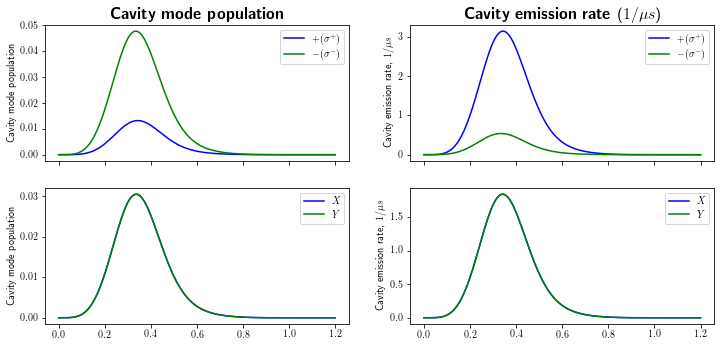

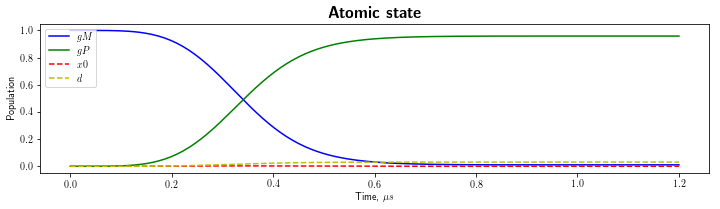

In [5]:
results.plot()

### Efficient running of multiple simulation and anaysis

It can be slow to compile the Hamiltonians used in these simulations, not to mention calculating the operators with which we analyse the result.  Fortunately we try to minimise the number of times these operations have to be performed.

For example, the Hamiltonian only needs to be re-compiled if a variable not passed in through the args dictionary changes.  So below, changing the birefringence requres re-compilation (boo), as does changing the laser pulse does (boo x 2), but changing the laser power does not (yay).

So let's set up these cases and run them through (along with a direct copy of the above system reference).

In [7]:
runner2 = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

cavity3=CavityBiref(g=g0,
                    kappa1=kappa1,
                    kappa2=kappa2,
                    deltaP=0*deltaP)

runner3 = ExperimentalRunner(atom=atom,
                            cavity=cavity3,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

laser_couplings2 = []

pulse_c_str = \
'''
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double complex pulse_c(float t, float t_start, float t_end):
    if t_start<=t<=t_end: return sin(pi*t/(t_start-t_end))**2
    else: return 0
'''

for g_state, x_state, delta, _ in Atom.get_couplings_sigma_plus(deltaL):
    laser_couplings2.append(LaserCoupling(omega0=omega0,
                                         g=g_state,
                                         x=x_state,
                                         deltaL=delta,
                                         args_ham={"length_pulse": length_pulse},
                                         pulse_shape=("pulse_c(t, 0, length_pulse)"),
                                         setup_pyx=[''],
                                         add_pyx=[pulse_c_str]))

runner4 = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings2,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

laser_couplings3 = []

for g_state, x_state, delta, _ in Atom.get_couplings_sigma_plus(deltaL):
    laser_couplings3.append(LaserCoupling(omega0=0.5*omega0,
                                         g=g_state,
                                         x=x_state,
                                         deltaL=delta,
                                         args_ham={"length_pulse": length_pulse},
                                         pulse_shape=("pulse_c(t, 0, length_pulse)"),
                                         setup_pyx=[''],
                                         add_pyx=[pulse_c_str]))

runner5 = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings3,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

Pre-compiled Hamiltonian, ExperimentalRunner_Hamiltonian_0_20243.pyx, is suitable to run this experiment.
No suitable pre-compiled Hamiltonian found.  Generating Cython file...

done.
	New file is ExperimentalRunner_Hamiltonian_1_20243.pyx.  Generated in 4.251 seconds.
No suitable pre-compiled Hamiltonian found.  Generating Cython file...

done.
	New file is ExperimentalRunner_Hamiltonian_2_20243.pyx.  Generated in 5.541 seconds.
Pre-compiled Hamiltonian, ExperimentalRunner_Hamiltonian_2_20243.pyx, is suitable to run this experiment.


In [8]:
results2 = runner2.run(psi0=psi0)
results3 = runner3.run(psi0=psi0)
results4 = runner4.run(psi0=psi0)
results5 = runner5.run(psi0=psi0)

Running simulation with 201 timesteps...

finished in 0.241 seconds
Running simulation with 201 timesteps...

finished in 0.266 seconds
Running simulation with 201 timesteps...finished in 0.102 seconds
Running simulation with 201 timesteps...finished in 0.087 seconds


Photon emission: 0.958
Photon emission in |X>, |Y>: 0.479 0.479
Spontaneous emission: 0.031


Photon emission: 0.477
Photon emission in |X>, |Y>: 0.238 0.238
Spontaneous emission: 0.003


Photon emission: 0.958
Photon emission in |X>, |Y>: 0.479 0.479
Spontaneous emission:

 0.031
Photon emission: 0.676
Photon emission in |X>, |Y>: 0.338 0.338
Spontaneous emission: 0.022


(<matplotlib.figure.Figure at 0x1253eaa90>,
 <matplotlib.figure.Figure at 0x125821dd8>)

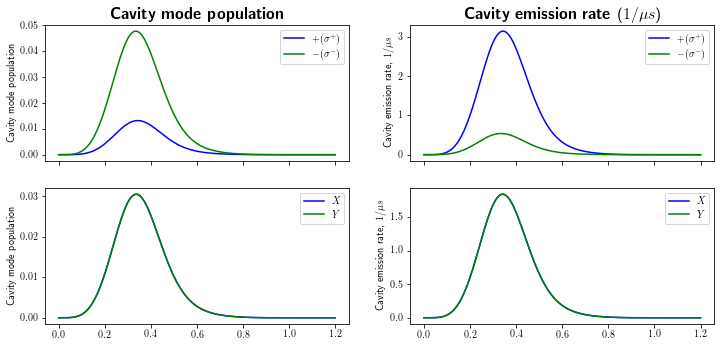

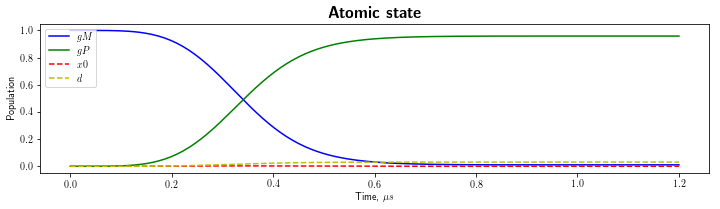

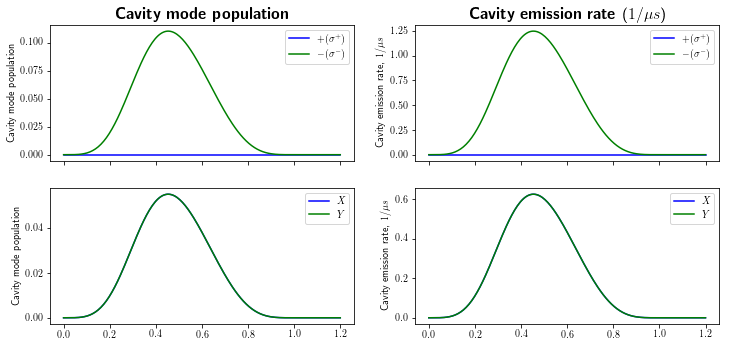

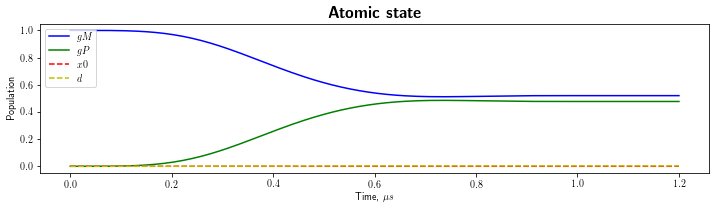

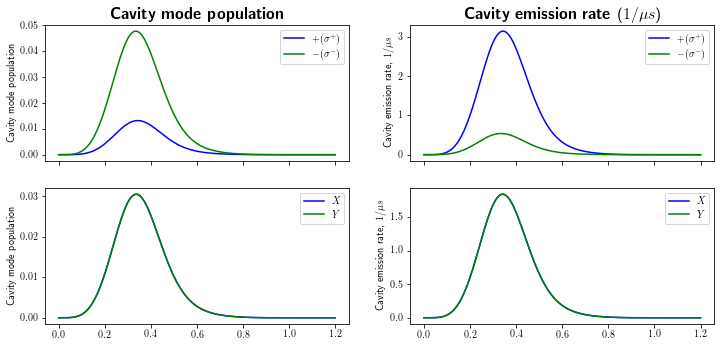

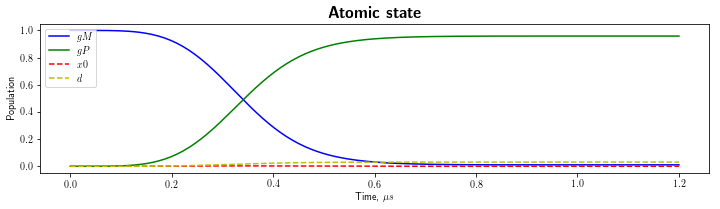

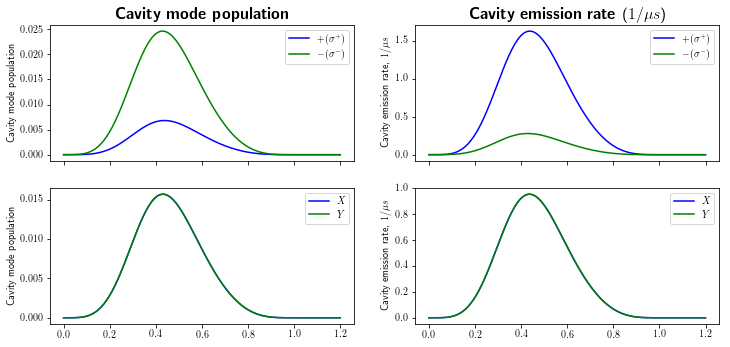

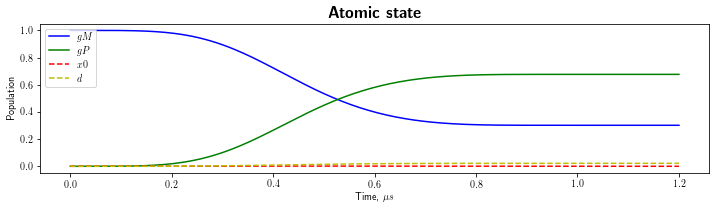

In [9]:
results2.plot()
results3.plot()
results4.plot()
results5.plot()

### Single-mode vs Birefringent cavity

If the cavity is not birefringent and doesn't have polarisation dependent decay, then we can reduce the dimension of our Hilbert space by using a single-mode cavity.

In [10]:
cavity6=CavityBiref(g=g0,
                    kappa1=(kappa1 + kappa2)/2,
                    kappa2=(kappa1 + kappa2)/2,
                    deltaP=0*deltaP)

runner6 = ExperimentalRunner(atom=atom,
                            cavity=cavity6,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

cavity7=Cavity(g=g0,
               kappa=(kappa1 + kappa2)/2)

runner7 = ExperimentalRunner(atom=atom,
                            cavity=cavity7,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

No suitable pre-compiled Hamiltonian found.  Generating Cython file...

done.
	New file is ExperimentalRunner_Hamiltonian_3_20243.pyx.  Generated in 4.159 seconds.
No suitable pre-compiled Hamiltonian found.  Generating Cython file...

done.
	New file is ExperimentalRunner_Hamiltonian_4_20243.pyx.  Generated in 4.175 seconds.


In [11]:
results6 = runner6.run(psi0=psi0)
results7 = runner7.run(psi0=psi0[:-1])

Running simulation with 201 timesteps...

finished in 0.261 seconds
Running simulation with 201 timesteps...

finished in 0.232 seconds


Photon emission: 0.95
Photon emission in |X>, |Y>: 0.475 0.475
Spontaneous emission: 0.05


Photon emission: 0.95
Spontaneous emission: 0.05


(<matplotlib.figure.Figure at 0x124fc4748>,
 <matplotlib.figure.Figure at 0x1266a3a20>)

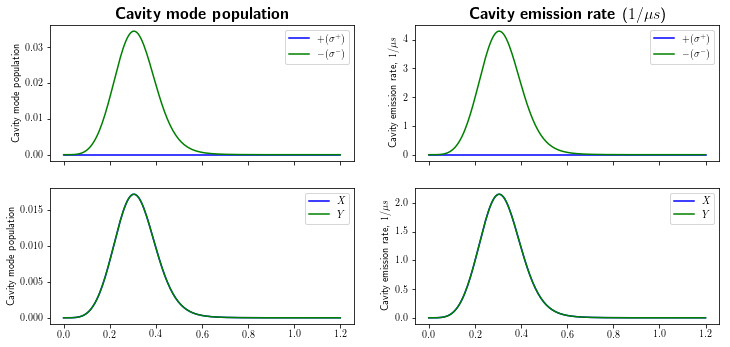

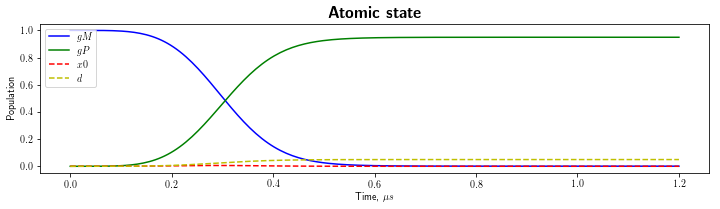

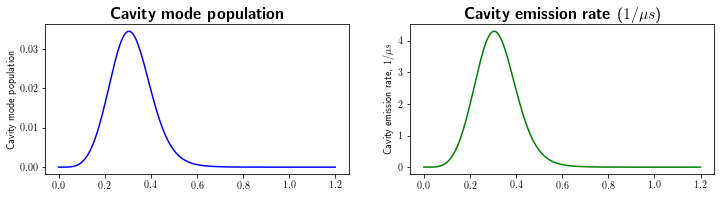

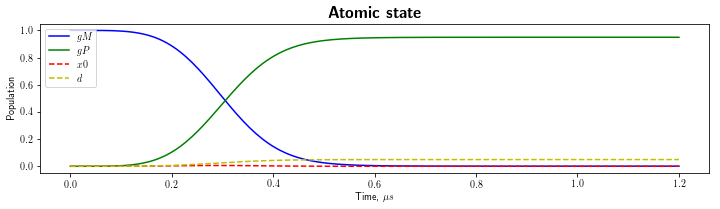

In [12]:
results6.plot()
results7.plot()